# Consumer Goods - Stock Analysis,  and LSTM Prediction vs Naive Approach Model

The purpose of this project is to explore stock price predicting via a LSTM model which we will compare to the naive forecast model for our stocks as well. The hope is to gain insight on why the naive forecast model is optimal for random walks while using a real life example. Although our model may not beat the naive model in the end, it may serve useful as a 'better than random guess' tool for some other analysis.

Stock levels (prices) tend to follow a pattern of cycles rather than seasonality. This along with numerous other factors tend to make stock levels random and therefore stochastic. Some think stocks follow a path of geometric brownian motion. That assumption along with advancements within Stochastic differential equations allowed for the derivation of black scholes formula, which is frequently used in modern options theory pricing.

Stock returns however, as we will see tend to follow a normal distribution over time. After plotting returns over the 20 year period for our stocks intuition says it may be a better idea to forecast direction of returns rather than stock prices since returns seem more stationary than price levels, and therefore will allow for models like ARIMA to be potentially used. 

Enough talk, lets start with our data preprocessing!


## Import Modules

In [1]:
import os
import glob
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')

## Some functions that will be helpful later...

In [2]:
# this function will allow us to quickly get rmse, takes in a test set and a predicted set (y_test,y_pred)
def return_rmse(test,predicted):
    
    rmse = math.sqrt(mean_squared_error(test, predicted))
    
    print("The root mean squared error is {}.".format(rmse))

In [3]:
# this function will be used later to help determine for each stock 
# adding which lag on predictions gives the best MSE score.
# takes in a pd.Dataframe() with columns "Pred" and "True" (y_test,y_pred)
def best_mse_lag(df, disp=False):
    
    df_pred = pd.Series(df["Pred"].reshape(-1))
    df_true = pd.Series(df["True"].reshape(-1))
    
    results = {}
    for i in range(1,20):
        df_pred_lag = df_pred.shift(-i)
        results[-i] = mean_squared_error(np.array(df_true[:-i]), np.array(df_pred_lag[:-i]))
        
    if disp ==True:
        print('result for {} is {}.'.format(-i, results[-i]))
            
    return min(results, key=results.get)

In [4]:
# this function is used to lag our predictions of our lstm model later, then plot it.
# takes in a pd.Dataframe() with columns "Pred" and "True" (y_test,y_pred), 
# how much to lag by (i.e. -> (-3)), and the index for xaxis of plot

def lag_stocks(df, lag, index, ticker, ret=False):
    df_pred = pd.Series(df["Pred"].reshape(-1))
    df_true = pd.Series(df["True"].reshape(-1))
    
    df_pred_lag = df_pred.shift(lag)
    
    mse_no_lag = mean_squared_error(np.array(df_true), np.array(df_pred))
    mse_w_lag = mean_squared_error(np.array(df_true[:lag]), np.array(df_pred_lag[:lag]))

    plt.figure(figsize=(15,5))
    plt.title("LSTM Prediction for {} with Lag of {},  MSE = {}".format(ticker, -lag, mse_w_lag))
    plt.plot(index, df_true)
    plt.plot(index, df_pred_lag)
    plt.legend(['actual', 'predicted'])
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    
    if ret == True:
        return df_pred_lag

In [26]:
# this function is used to shift our predictions of our lstm model later, then plot it.
# takes in a pd.Dataframe() with columns "Pred" and "True" (y_test,y_pred), and the index for xaxis of plot.

def naive_stocks(df, index, ticker, ret=False):
    df_true = pd.Series(df["True"].reshape(-1))
    
    df_pred_lag = df_true.shift(1)
    
    mse_w_lag = mean_squared_error(np.array(df_true[1:]), np.array(df_pred_lag[1:]))

    plt.figure(figsize=(15,5))
    plt.title("Naive Predictions for {},  MSE = {}".format(ticker, mse_w_lag))
    plt.plot(index, df_true)
    plt.plot(index, df_pred_lag)
    plt.legend(['actual', 'predicted'])
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    
    if ret == True:
        return df_pred_lag

In [27]:
# this function is used to zoom in on the above naive forecast
# takes in a pd.Dataframe() with columns "Pred" and "True" (y_test,y_pred), and the index for xaxis of plot.

def zoom_naive_stocks(df, index, ticker, ret=False):
    df_pred = pd.Series(df["Pred"].reshape(-1))
    df_true = pd.Series(df["True"].reshape(-1))
    
    df_pred_lag = df_true.shift(1)
    
    mse_w_lag = mean_squared_error(np.array(df_true[1:]), np.array(df_pred_lag[1:]))
    
    plt.figure(figsize=(15,5))
    plt.title("Naive Prediction for {} with shift of 1 day,  MSE = {}".format(ticker, mse_w_lag))
    plt.plot(index[:100], df_true[:100])
    plt.plot(index[:100], df_pred_lag[:100])
    plt.legend(['Actual', 'Predicted'])
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    
    if ret == True:
        return df_pred_lag

## Set path to cwd and read in stock files

In [7]:
# use glob to get all the csv files 
# in the folder
path = os.getcwd()
ticker_csv_files = glob.glob(os.path.join(path, "final_*.csv"))
print(ticker_csv_files)

['/Users/jarrodmautz/Documents/Python Projects/stock_proj/final_CL_df.csv', '/Users/jarrodmautz/Documents/Python Projects/stock_proj/final_^GSPC_df.csv', '/Users/jarrodmautz/Documents/Python Projects/stock_proj/final_PG_df.csv', '/Users/jarrodmautz/Documents/Python Projects/stock_proj/final_UL_df.csv', '/Users/jarrodmautz/Documents/Python Projects/stock_proj/final_JNJ_df.csv', '/Users/jarrodmautz/Documents/Python Projects/stock_proj/final_KMB_df.csv']


## Get list of stocks from list of files

In [8]:
stock_list = []
for f in ticker_csv_files:
    stock_list.append(f.split("l_")[-1].split('_')[0])

print(stock_list)

stock_df = dict(map(lambda i,j : (i,j), stock_list,ticker_csv_files))

['CL', '^GSPC', 'PG', 'UL', 'JNJ', 'KMB']


## Read in each stock's data

In [9]:
stocks = {}
# loop over the list of csv files
for i, f in stock_df.items():
    # read the csv file
    stocks[i] = pd.read_csv(f, parse_dates = ['date'])
    stocks[i].set_index('date', inplace=True)
    stocks[i].drop(['ticker', 'volume'], axis=1, inplace=True) # drop categorical and redundant variable 
    stocks[i] = stocks[i].iloc[20:, :] # for the first month some indicators are NaN so drop first month

    # print the location and filename
    print('Location:', f)
    print('File Name:', f.split("final_")[-1])

# print one of our stocks dataset
print('Content:')
display(stocks['PG'])
print()

Location: /Users/jarrodmautz/Documents/Python Projects/stock_proj/final_CL_df.csv
File Name: CL_df.csv
Location: /Users/jarrodmautz/Documents/Python Projects/stock_proj/final_^GSPC_df.csv
File Name: ^GSPC_df.csv
Location: /Users/jarrodmautz/Documents/Python Projects/stock_proj/final_PG_df.csv
File Name: PG_df.csv
Location: /Users/jarrodmautz/Documents/Python Projects/stock_proj/final_UL_df.csv
File Name: UL_df.csv
Location: /Users/jarrodmautz/Documents/Python Projects/stock_proj/final_JNJ_df.csv
File Name: JNJ_df.csv
Location: /Users/jarrodmautz/Documents/Python Projects/stock_proj/final_KMB_df.csv
File Name: KMB_df.csv
Content:


open        high         low       close    adjclose  \
date                                                                     
2002-01-31   40.250000   41.060001   40.200001   40.317656   23.396101   
2002-02-01   40.840000   41.650002   40.700001   40.994797   23.651031   
2002-02-04   41.285000   42.110001   41.215000   41.243438   23.688253   
2002-02-05   41.224998   41.535000   40.860001   41.290032   23.665342   
2002-02-06   40.990002   41.590000   40.865002   41.262010   23.630978   
...                ...         ...         ...         ...         ...   
2022-09-26  135.580002  136.820007  134.990005  135.730379  135.710007   
2022-09-27  135.960007  136.940002  131.710007  133.105111  131.979996   
2022-09-28  133.020004  133.020004  131.190002  132.317530  131.979996   
2022-09-29  131.869995  131.869995  128.259995  129.785257  128.699997   
2022-09-30  129.000000  129.039993  126.209999  127.310577  126.250000   

              BB_UPPER   BB_MIDDLE    BB_LOWER       pivot          s1  ...  \
date                                                                    ...   
2002-01-31   40.275918   39.321866   38.367814   39.117951   38.737862  ...   
2002-02-01   40.591052   39.386413   38.181775   40.525886   40.197366  ...   
2002-02-04   40.943369   39.480618   38.017866   41.114933   40.752033  ...   
2002-02-05   41.244330   39.597771   37.951211   41.522813   41.180923  ...   
2002-02-06   41.485905   39.715873   37.945840   41.228344   40.970495  ...   
...                ...         ...         ...         ...         ...  ...   
2022-09-26  141.611196  138.162100  134.713004  135.409303  134.435202  ...   
2022-09-27  141.312031  137.707730  134.103430  135.846797  135.147736  ...   
2022-09-28  141.329318  137.284420  133.239522  133.918373  131.920515  ...   
2022-09-29  142.017398  136.834026  131.650655  132.175846  131.476785  ...   
2022-09-30  142.791917  136.230258  129.668600  129.971749  128.592729  ...   

               ema60     ema20     ema10      ema5   ema5Vol  realGDP_(qrt)  \
date                                                                          
2002-01-31  1.024211  1.023628  1.022747  1.021255  2.005979       3263.869   
2002-02-01  1.039099  1.037755  1.035639  1.031681  1.318678       3263.869   
2002-02-04  1.042947  1.040812  1.037469  1.031317  1.141711       3263.869   
2002-02-05  1.041824  1.038977  1.034596  1.026852  0.893308       3263.869   
2002-02-06  1.039048  1.035593  1.030396  1.021655  0.929101       3263.869   
...              ...       ...       ...       ...       ...            ...   
2022-09-26  0.936518  0.963840  0.977658  0.988496  1.142632       4985.795   
2022-09-27  0.919634  0.947671  0.962357  0.974350  1.155792       4985.795   
2022-09-28  0.915481  0.944670  0.960447  0.973682  1.430193       4985.795   
2022-09-29  0.899465  0.929841  0.947054  0.962257  0.979193       4985.795   
2022-09-30  0.884020  0.915945  0.935031  0.952817  1.233515       4985.795   

            consumerPriceIndex_(mo)  consumerSentiment_(mo)  retailSales_(mo)  \
date                                                                            
2002-01-31                  177.100                    93.0            230546   
2002-02-01                  177.800                    90.7            228084   
2002-02-04                  177.800                    90.7            228084   
2002-02-05                  177.800                    90.7            228084   
2002-02-06                  177.800                    90.7            228084   
...                             ...                     ...               ...   
2022-09-26                  296.808                    58.2            575365   
2022-09-27                  296.808                    58.2            575365   
2022-09-28                  296.808                    58.2            575365   
2022-09-29                  296.808                    58.2            575365   
2022-09-30                 

## Lets check corrolation amongst features to see what variables may be redundant and can be removed

<AxesSubplot:>

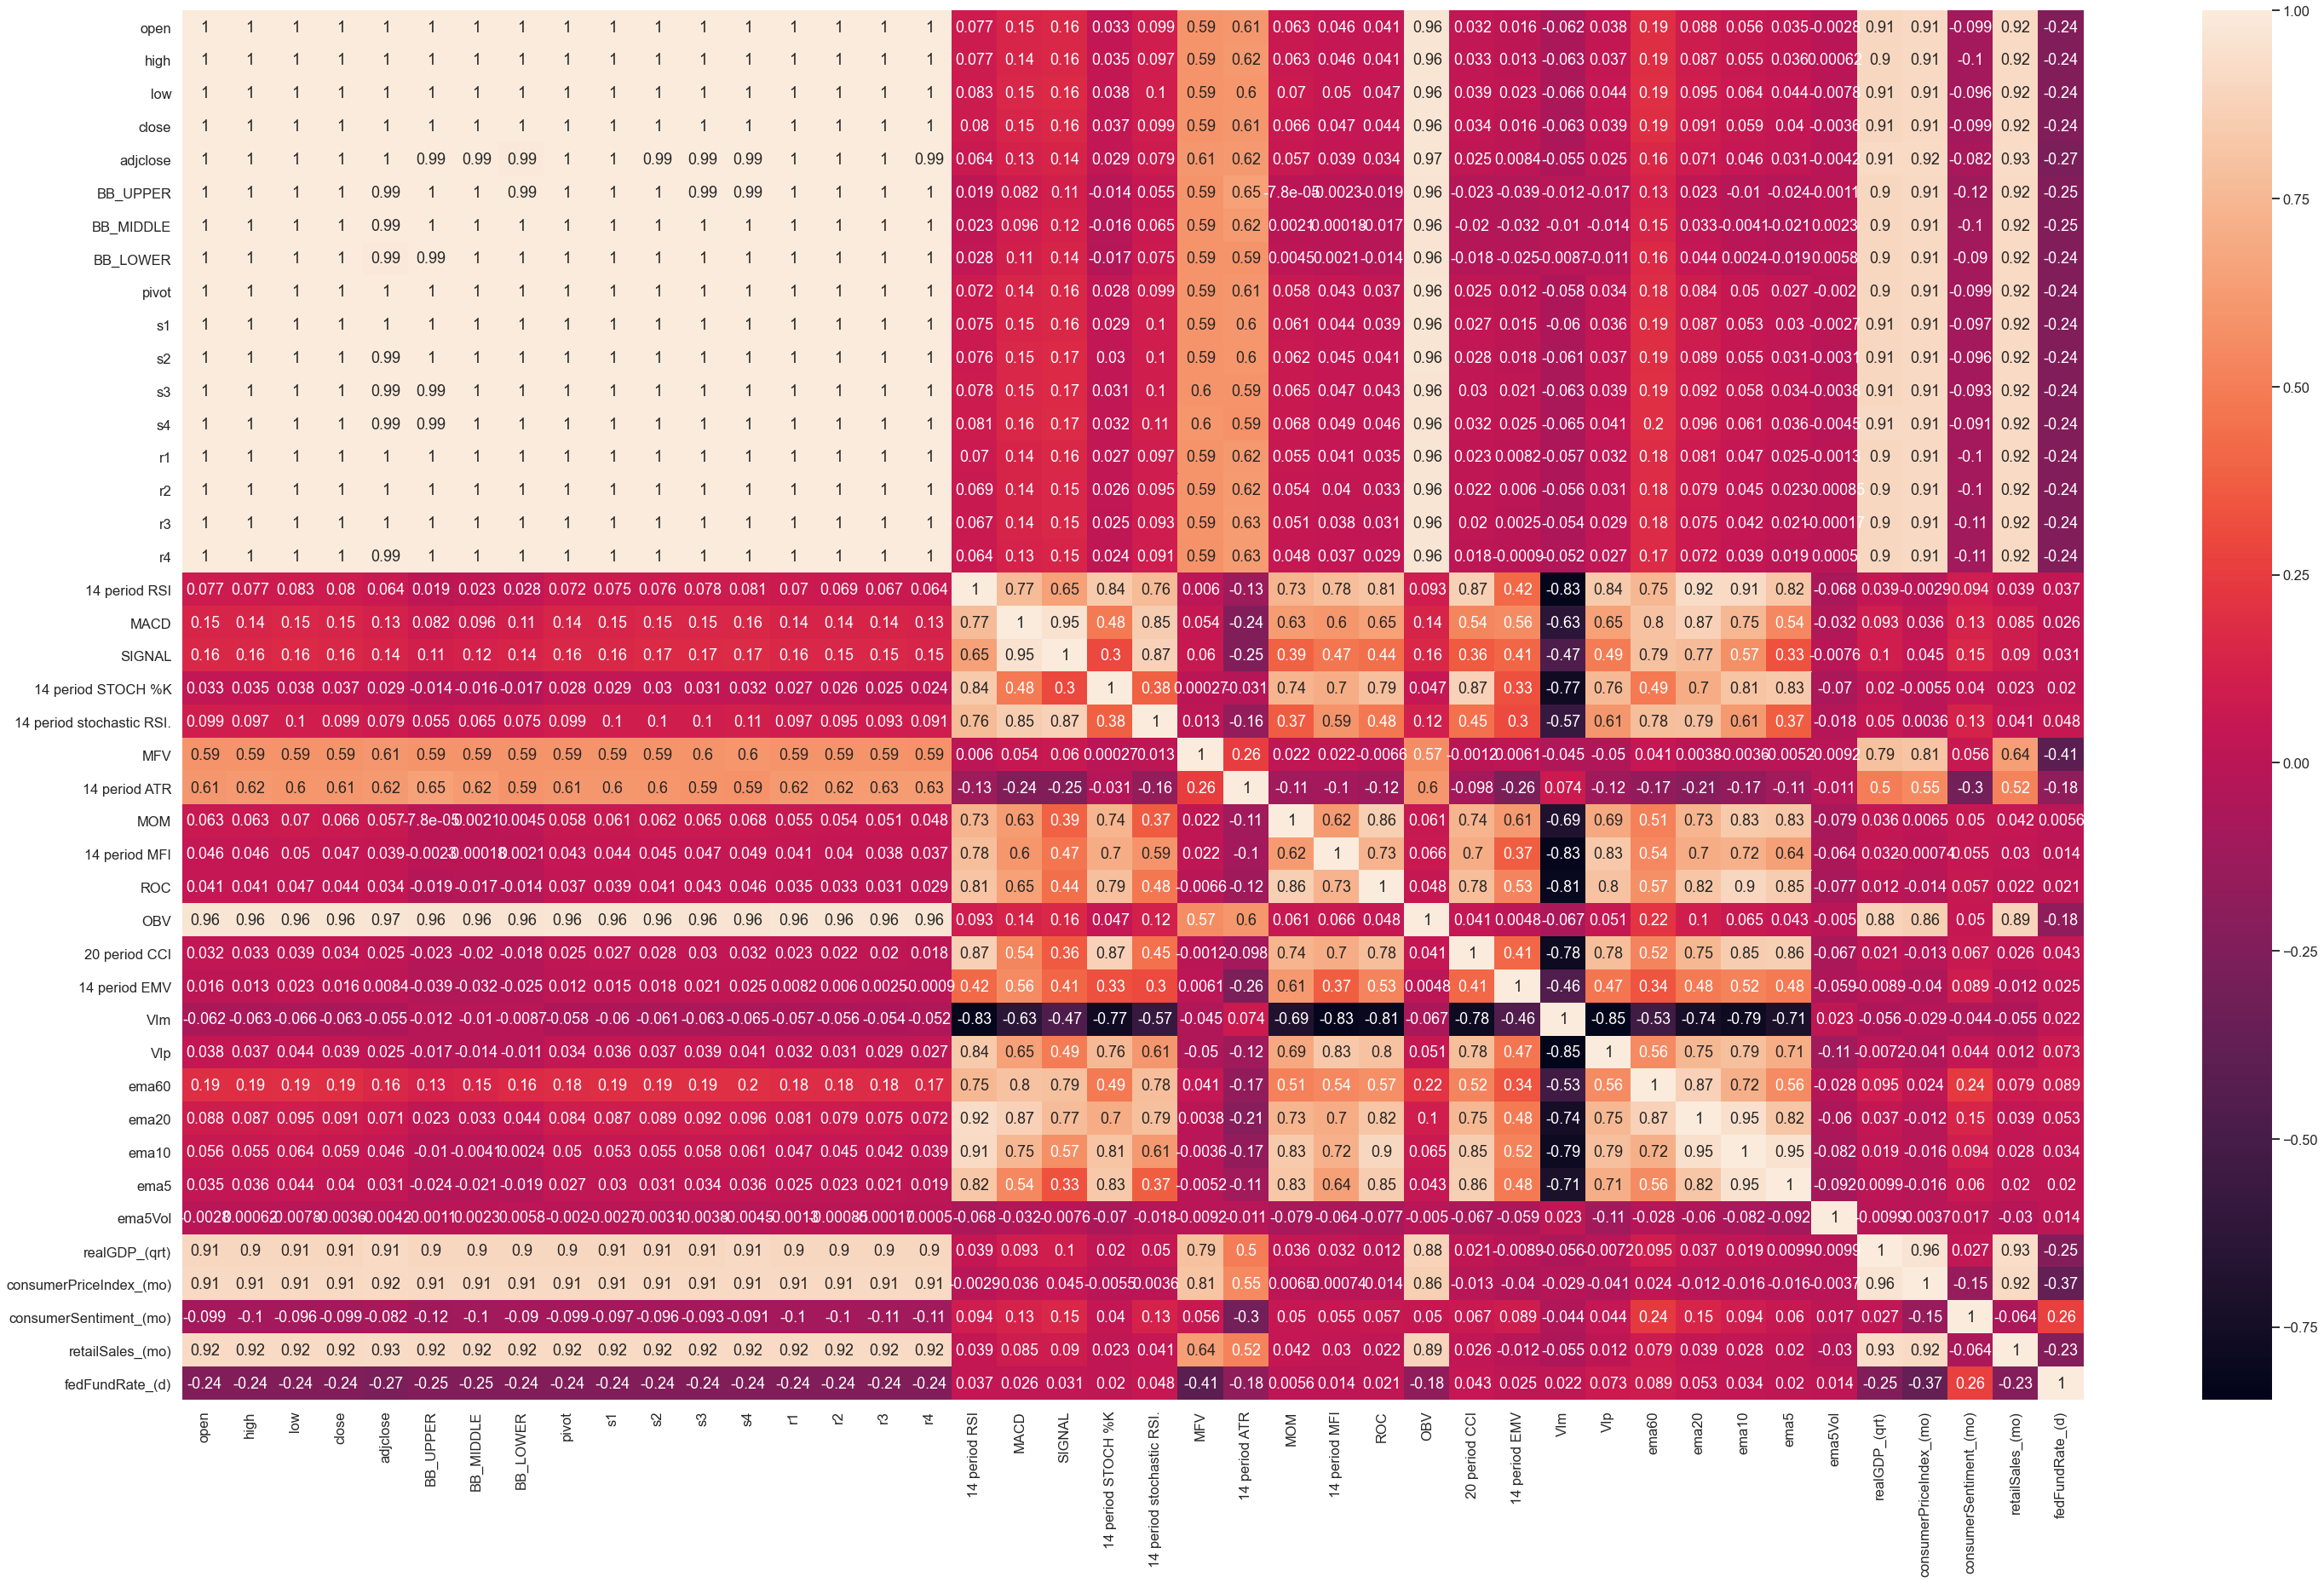

In [10]:
plt.figure(figsize=(50,30))
sns.heatmap(stocks['PG'].corr(), annot=True)

## Get X and Y column names
Here we are getting rid of the highly correlated variables. We then pass the remaining col names in as X. Y will be our 'adjclose' column.

In [11]:
cols = stocks[i].columns.values.tolist()
print(cols)
print()

remove_features = ['close', 'adjclose', 's1', 's2', 's3', 's4', 'r1', 'r2', 'r3', 'r4', 'ema10', 'consumerSentiment_(mo)']
X_list = [i for i in cols if i not in (remove_features)]
print(X_list)
y_cols = 'adjclose'

['open', 'high', 'low', 'close', 'adjclose', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER', 'pivot', 's1', 's2', 's3', 's4', 'r1', 'r2', 'r3', 'r4', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', '14 period stochastic RSI.', 'MFV', '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI', '14 period EMV', 'VIm', 'VIp', 'ema60', 'ema20', 'ema10', 'ema5', 'ema5Vol', 'realGDP_(qrt)', 'consumerPriceIndex_(mo)', 'consumerSentiment_(mo)', 'retailSales_(mo)', 'fedFundRate_(d)']

['open', 'high', 'low', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER', 'pivot', '14 period RSI', 'MACD', 'SIGNAL', '14 period STOCH %K', '14 period stochastic RSI.', 'MFV', '14 period ATR', 'MOM', '14 period MFI', 'ROC', 'OBV', '20 period CCI', '14 period EMV', 'VIm', 'VIp', 'ema60', 'ema20', 'ema5', 'ema5Vol', 'realGDP_(qrt)', 'consumerPriceIndex_(mo)', 'retailSales_(mo)', 'fedFundRate_(d)']


# Train Test Split the data at 2018-May-01 for ~80/20 split

In [12]:
def split_time_series(dataframe, border, col):
    return dataframe.loc[:border, col], dataframe.loc[border:, col]

In [13]:
tt_stocks = {}
for i in stock_list:
    tt_stocks[i] = {}
    tt_stocks[i]['X'], tt_stocks[i]['y'] = {}, {}
    
    tt_stocks[i]['X']['Train'], tt_stocks[i]['X']['Test'] = split_time_series(stocks[i], "2018-05-01", X_list)
    tt_stocks[i]['y']['Train'], tt_stocks[i]['y']['Test'] = split_time_series(stocks[i], "2018-05-01", y_cols)

display(tt_stocks)

{'CL': {'X': {'Train':                  open       high        low   BB_UPPER  BB_MIDDLE   BB_LOWER  \
   date                                                                           
   2002-01-31  28.125000  28.575001  27.875000  28.723515  28.174424  27.625333   
   2002-02-01  28.575001  28.674999  28.150000  28.674842  28.163952  27.653062   
   2002-02-04  28.575001  28.750000  28.045000  28.672919  28.162981  27.653043   
   2002-02-05  26.875000  28.174999  26.745001  28.671598  28.168248  27.664898   
   2002-02-06  27.875000  27.875000  27.450001  28.682995  28.158800  27.634605   
   ...               ...        ...        ...        ...        ...        ...   
   2018-04-25  66.400002  67.059998  66.239998  74.179944  70.513057  66.846169   
   2018-04-26  66.389999  66.879997  66.239998  74.399168  70.328567  66.257966   
   2018-04-27  65.889999  67.120003  64.839996  74.467941  70.094720  65.721499   
   2018-04-30  65.919998  66.150002  64.989998  74.651954  69.85236

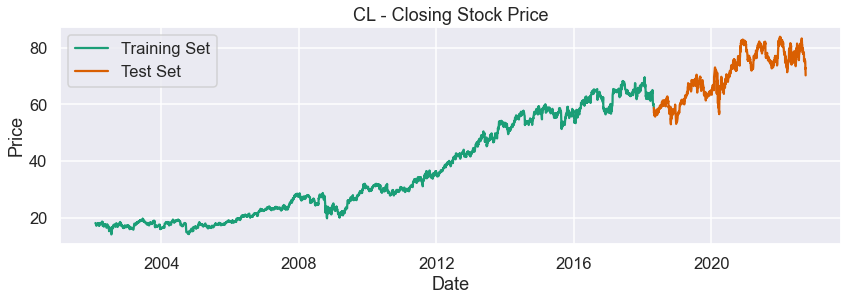

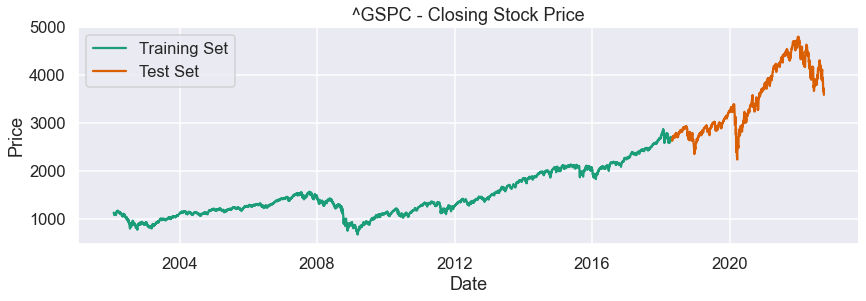

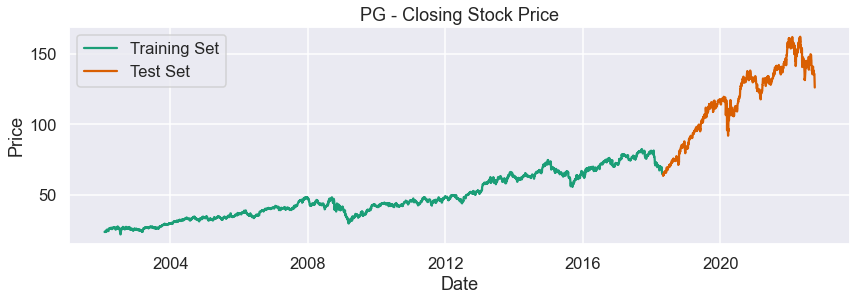

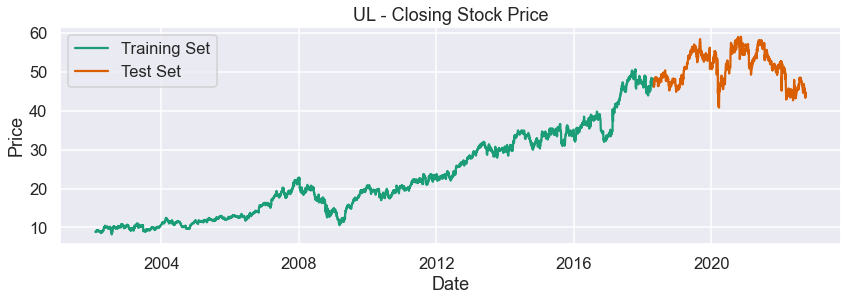

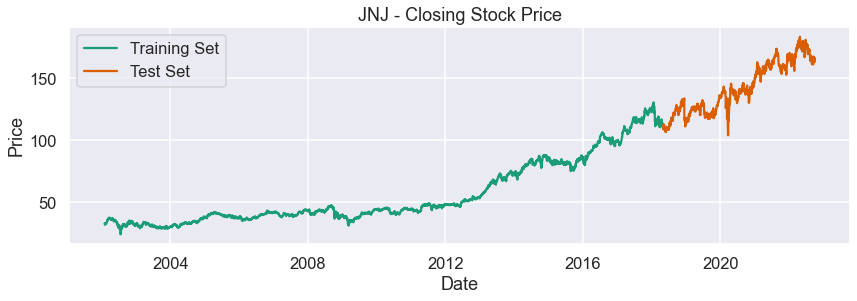

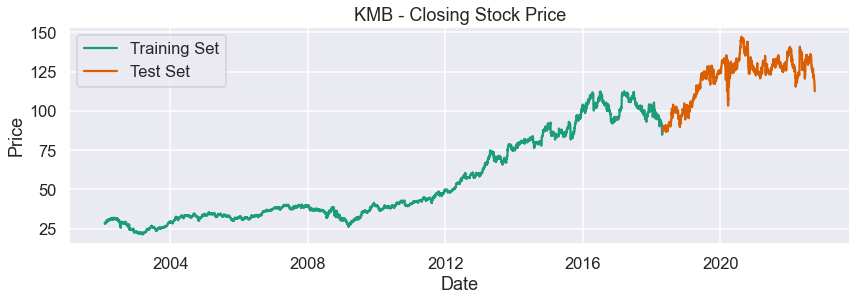

In [14]:
for i in stock_list:
    plt.figure(figsize=(14,4))
    plt.plot(tt_stocks[i]['y']["Train"])
    plt.plot(tt_stocks[i]['y']["Test"])
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title( i + " - Closing Stock Price")

## MinMax Scaling the data

This is a major topic of discussion as stock prices tend to go upwards over time. This causes problems because in theory a max range of 1 may not be the best choice because if we get a higher price our data will no longer be extrapolatable. 

Time series data typically consists of three components for forecasting extrapolatability,

In [15]:
# Scaling the training set
transform_train = {}
transform_test = {}
scaler = {}

for i in (stock_list):
    
    transform_train[i], transform_test[i] = {}, {}
    
    sc = MinMaxScaler(feature_range=(0,1))
    X_tr = np.array(tt_stocks[i]['X']['Train'])
    y_tr = np.array(tt_stocks[i]['y']['Train']).reshape(-1, 1)
    X_te = np.array(tt_stocks[i]['X']['Test'])
    y_te = np.array(tt_stocks[i]['y']['Test']).reshape(-1, 1)
    transform_train[i]['X'] = sc.fit_transform(X_tr)
    transform_train[i]['y'] = sc.fit_transform(y_tr )
    transform_test[i]['X'] = sc.fit_transform(X_te)
    transform_test[i]['y'] = sc.fit_transform(y_te)
    scaler[i] = sc
    
display(transform_train[i])

{'X': array([[0.1592313 , 0.1647873 , 0.16351096, ..., 0.        , 0.00916328,
         0.33705773],
        [0.16684675, 0.16696076, 0.1677087 , ..., 0.00939749, 0.        ,
         0.32216015],
        [0.16931928, 0.16755351, 0.16670923, ..., 0.00939749, 0.        ,
         0.31657356],
        ...,
        [0.62874808, 0.64976215, 0.63796316, ..., 0.98601117, 0.71506731,
         0.30912477],
        [0.65267985, 0.65099868, 0.64515597, ..., 0.98601117, 0.71506731,
         0.30726257],
        [0.63462786, 0.63677898, 0.63441893, ..., 1.        , 0.87906104,
         0.30912477]]),
 'y': array([[0.08214791],
        [0.0818858 ],
        [0.07942238],
        ...,
        [0.75286751],
        [0.74370867],
        [0.74059302]])}

In [16]:
show_shape = []
for i in stock_list:
    shape = {}
    shape["X_train"] = transform_train[i]['X'].shape
    shape["y_train"] = transform_train[i]['y'].shape
    shape["X_test"] = transform_test[i]['X'].shape
    shape["y_test"] = transform_test[i]['y'].shape
    show_shape.append(shape)

pd.DataFrame(show_shape, index=stock_list)

X_train    y_train      X_test     y_test
CL     (4091, 30)  (4091, 1)  (1114, 30)  (1114, 1)
^GSPC  (4091, 30)  (4091, 1)  (1114, 30)  (1114, 1)
PG     (4091, 30)  (4091, 1)  (1114, 30)  (1114, 1)
UL     (4091, 30)  (4091, 1)  (1114, 30)  (1114, 1)
JNJ    (4091, 30)  (4091, 1)  (1114, 30)  (1114, 1)
KMB    (4091, 30)  (4091, 1)  (1114, 30)  (1114, 1)

Now our data is almost ready to input, we just need to create a sequence since LSTM models are meant to analyze sequences of data.

<br>

## Creating our Sequence to input into LSTM

For both our trainset and our test set we will be splitting up our transformed data into a sequence of 40 days worth of data. Afterwards, the shape of our data should be as follows: (num_days-sequence, sequence, num_X_Variables)

In [17]:
trainset = {}
testset = {}

for i in stock_list:
   
    trainset[i] = {}
    X_train = []
    y_train = []
    
    #will give our last numbers for range in loop below
    endTr = len(transform_train[i]['X'])
    endTe = len(transform_test[i]['y'])
    
    for j in range(20,endTr):
        X_train.append(transform_train[i]['X'][j-20:j,:])
        y_train.append(transform_train[i]['y'][j,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[i]["X"] = X_train
    trainset[i]["y"] = y_train
    
    testset[i] = {}
    X_test = []
    y_test = [] 
    
    for j in range(20,endTe):
        X_test.append(transform_test[i]['X'][j-20:j,:])
        y_test.append(transform_test[i]['y'][j,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[i]["X"] = X_test
    testset[i]["y"] = y_test


In [18]:
show_shape = []
for i in stock_list:
    shape = {}
    shape["X_train"] = transform_train[i]['X'].shape
    shape["y_train"] = transform_train[i]['y'].shape
    shape["X_test"] = transform_test[i]['X'].shape
    shape["y_test"] = transform_test[i]['y'].shape
    show_shape.append(shape)

pd.DataFrame(show_shape, index=stock_list)

X_train    y_train      X_test     y_test
CL     (4091, 30)  (4091, 1)  (1114, 30)  (1114, 1)
^GSPC  (4091, 30)  (4091, 1)  (1114, 30)  (1114, 1)
PG     (4091, 30)  (4091, 1)  (1114, 30)  (1114, 1)
UL     (4091, 30)  (4091, 1)  (1114, 30)  (1114, 1)
JNJ    (4091, 30)  (4091, 1)  (1114, 30)  (1114, 1)
KMB    (4091, 30)  (4091, 1)  (1114, 30)  (1114, 1)

## Creating our LSTM and running for each stock

In [19]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop', loss='mean_squared_error')
# Fitting to the training set
for i in stock_list:
    print("Fitting to", i)
    regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=20, batch_size=200)

Fitting to CL
Epoch 1/20
21/21 [==============================] - 30s 428ms/step - loss: 0.0516
Epoch 2/20
21/21 [==============================] - 5s 233ms/step - loss: 0.0183
Epoch 3/20
21/21 [==============================] - 5s 222ms/step - loss: 0.0164
Epoch 4/20
21/21 [==============================] - 6s 273ms/step - loss: 0.0145
Epoch 5/20
21/21 [==============================] - 4s 186ms/step - loss: 0.0126
Epoch 6/20
21/21 [==============================] - 4s 173ms/step - loss: 0.0109
Epoch 7/20
21/21 [==============================] - 3s 158ms/step - loss: 0.0110
Epoch 8/20
21/21 [==============================] - 3s 164ms/step - loss: 0.0112
Epoch 9/20
21/21 [==============================] - 6s 300ms/step - loss: 0.0095
Epoch 10/20
21/21 [==============================] - 7s 342ms/step - loss: 0.0098
Epoch 11/20
21/21 [==============================] - 4s 178ms/step - loss: 0.0088
Epoch 12/20
21/21 [==============================] - 4s 203ms/step - loss: 0.0095
Epoch 13/2

## Plot the predictions against our actual test values

We first will have to inverse transform our scaled test set and our predictions on our X_test set. Then we have to find the MSE for our predictions for each stock. 

35/35 [==============================] - 1s 15ms/step


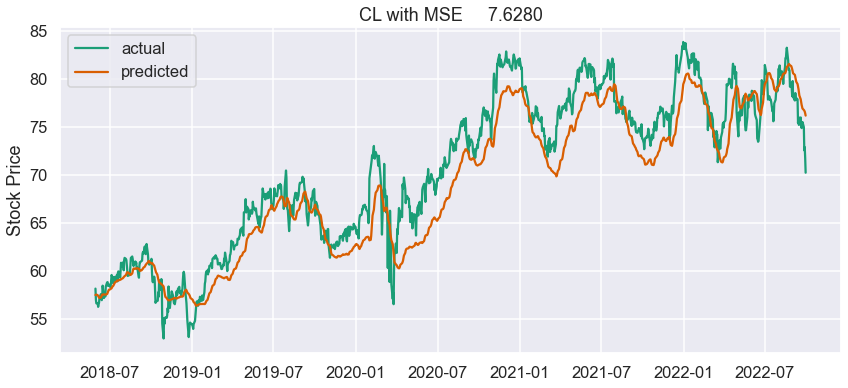

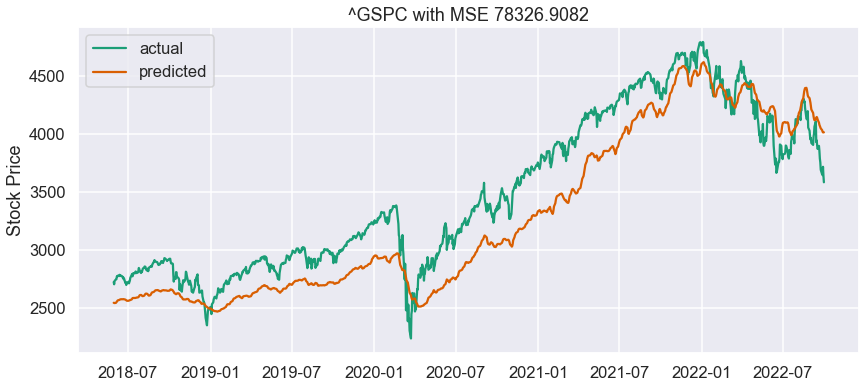

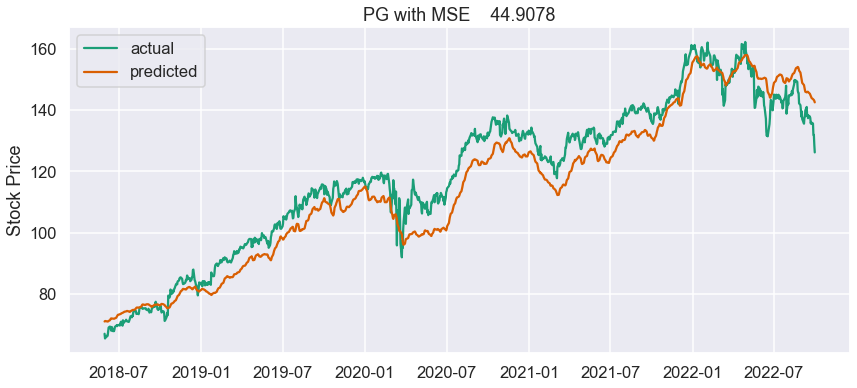

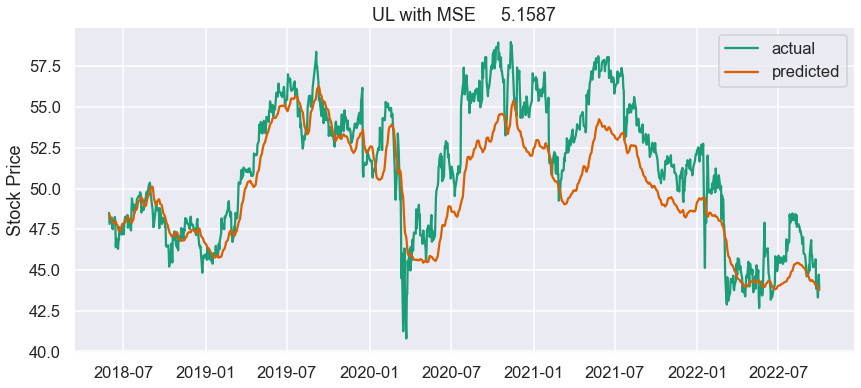

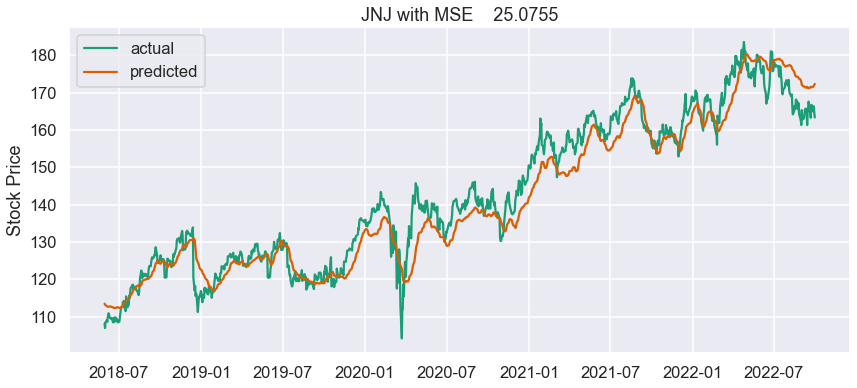

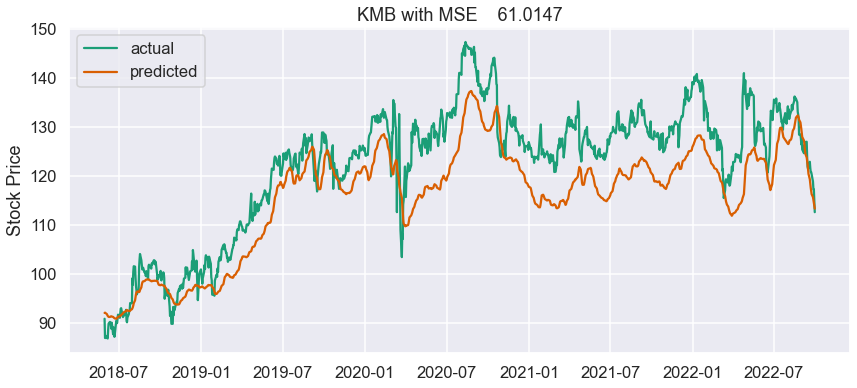

In [20]:
idx = tt_stocks[i]['y']["Test"][20:].index

pred_result = {}
for i in stock_list:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
    
    MSE = mean_squared_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred
    
    plt.figure(figsize=(14,6))
    plt.title("{} with MSE {:10.4f}".format(i,MSE))
    plt.plot(idx, y_true)
    plt.plot(idx, y_pred)
    plt.legend(['actual', 'predicted'])
    plt.ylabel('Date')
    plt.ylabel('Stock Price')

## Add lag to our predictions, choose lag with lowest MSE, plot new lagged predictions

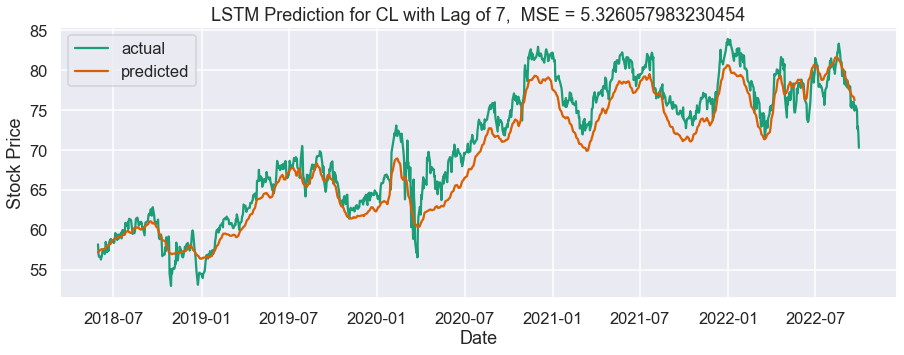

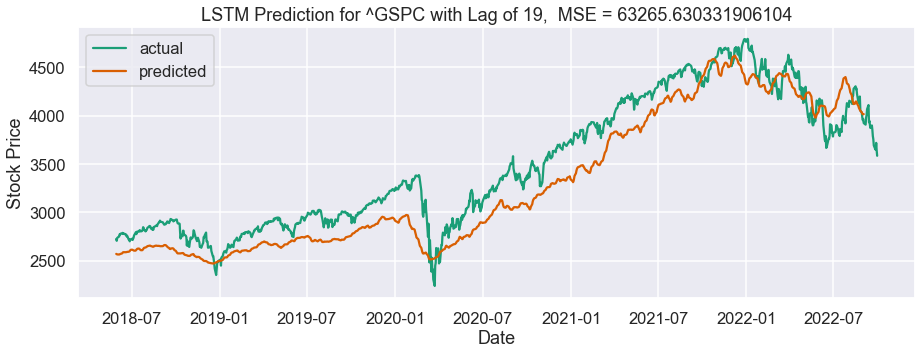

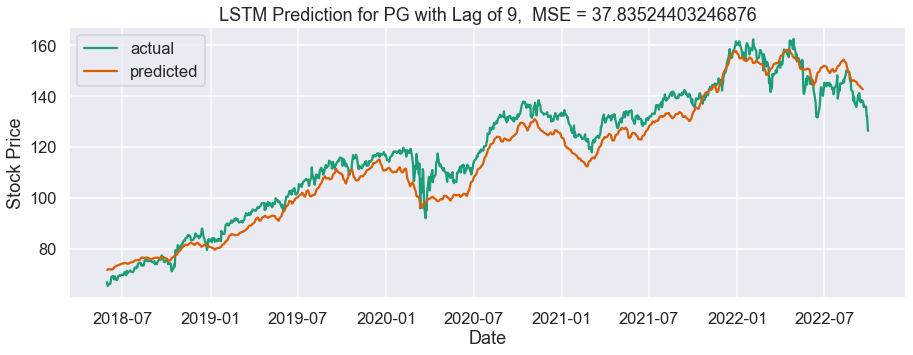

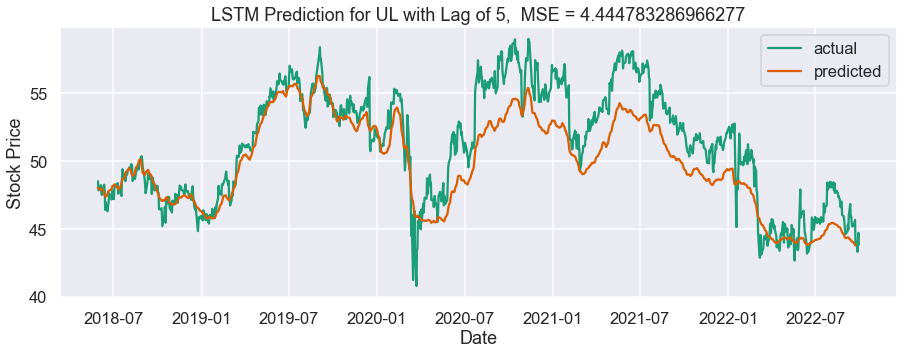

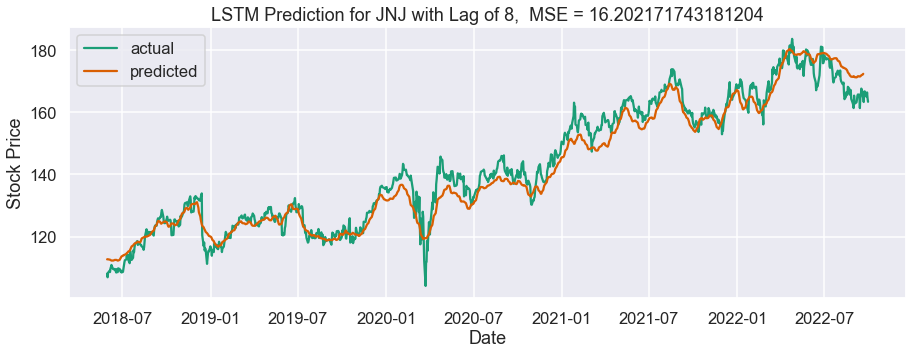

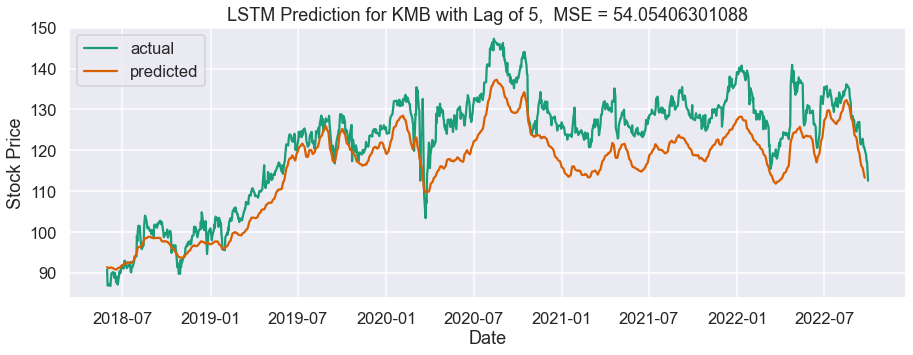

In [21]:
idx = tt_stocks[i]['y']["Test"][20:].index

for i in stock_list:
    stock_lag = best_mse_lag(pred_result[i])
    lag_stocks(pred_result[i], stock_lag, idx, i)

## Display the Naive Forcast for each stock and compare MSE

One of the simplest and most important models in time series forecasting is the random walk model. This model assumes that in each period the variable takes a random step away from its previous value, and the steps are independently and identically distributed in size ('i.i.d.'). 

It predicts that all future values will equal the last observed value. In reality we do not expect the values to all be the exact same, but that future values are equally likely to be higher or lower. Because of this, this method is typically known as the naive method. 

To plot the naive forecast we simply will shift our data one day for each timestep (since the model always predicts the previous days price).

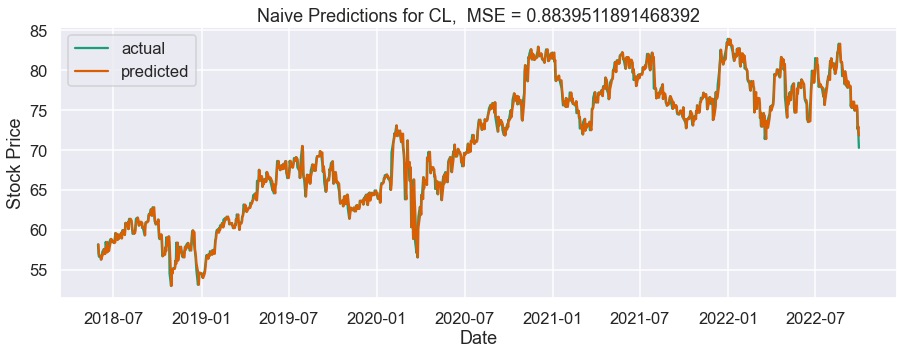

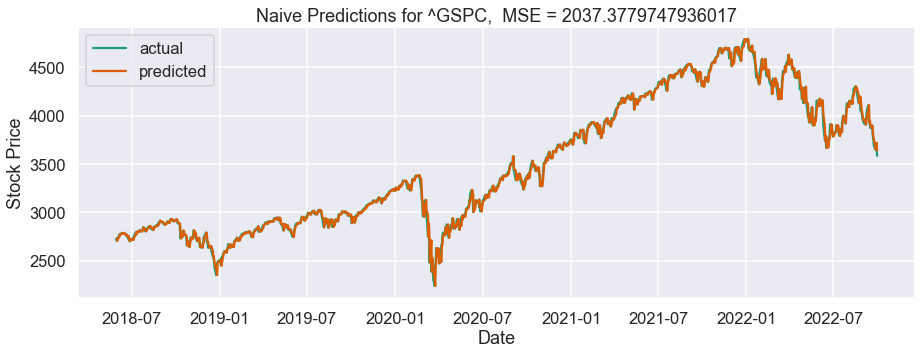

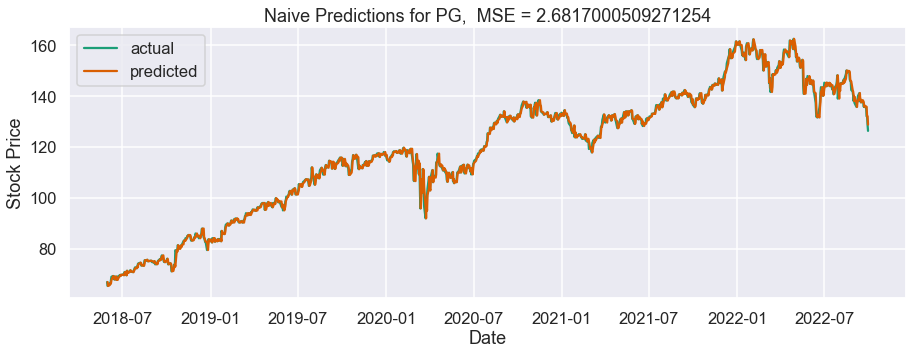

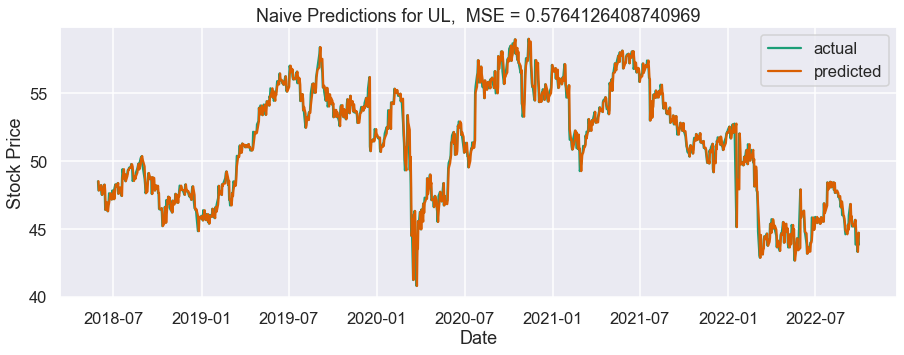

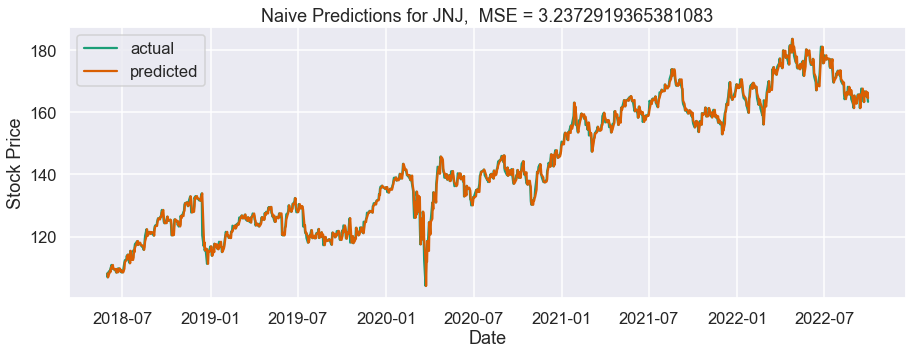

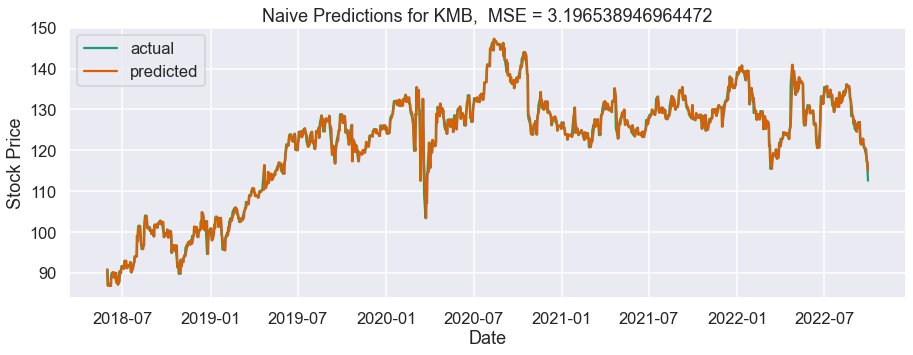

In [28]:
for i in stock_list:
    naive_stocks(pred_result[i], idx, i)

This plot gives the illusion of a very good model, when we are in fact only predicting the value observed at the previous timestep. Thus we see how hard it is to accurately predict price levels. Our sophisticated model fails to beat the naive forecast. Thus we have seen practical evidence that the naive forecast is the optimal model for random walks such as stock levels. 

We can zoom in a bit to really show the point.

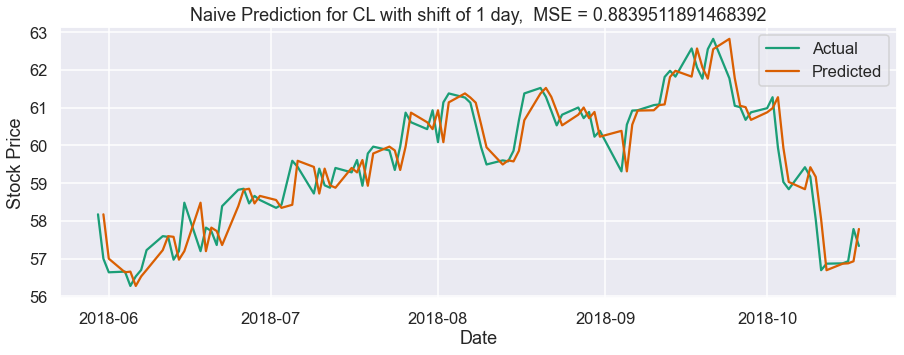

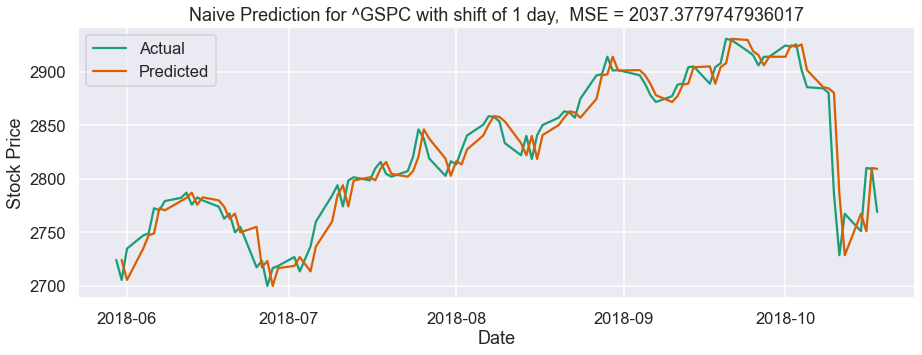

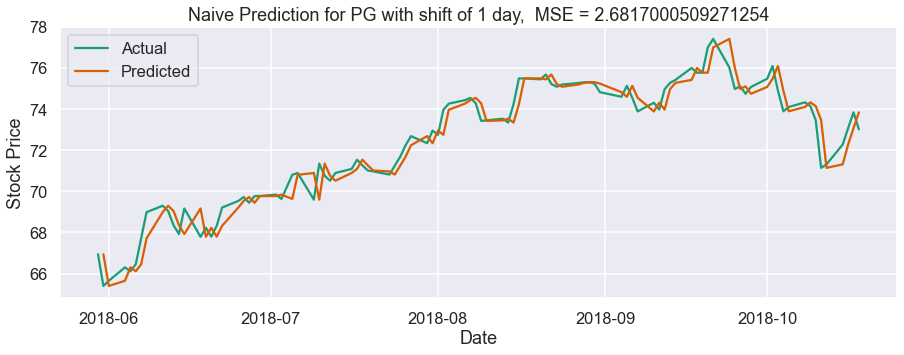

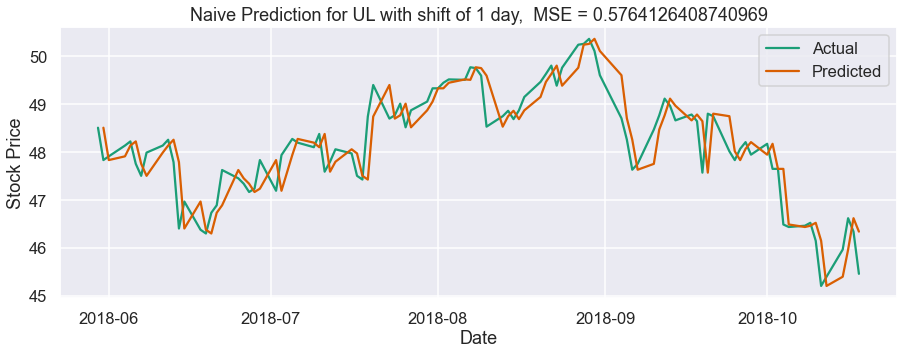

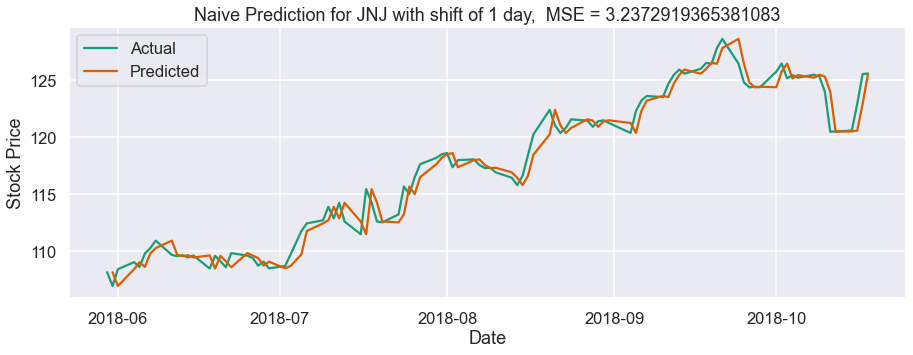

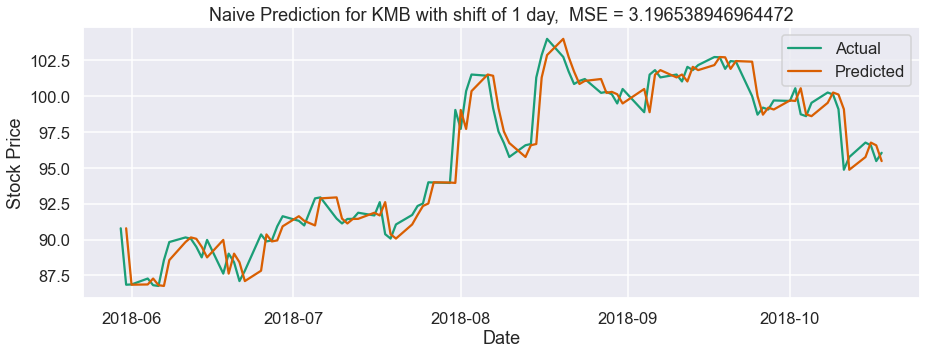

In [29]:
for i in stock_list:
    zoom_naive_stocks(pred_result[i], idx, i)

# Looking at Returns

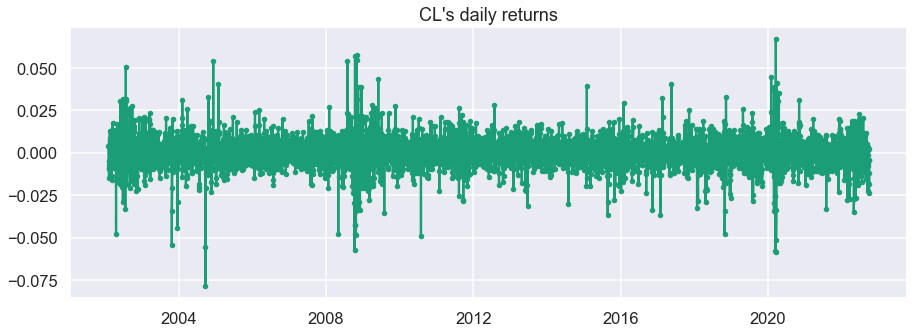

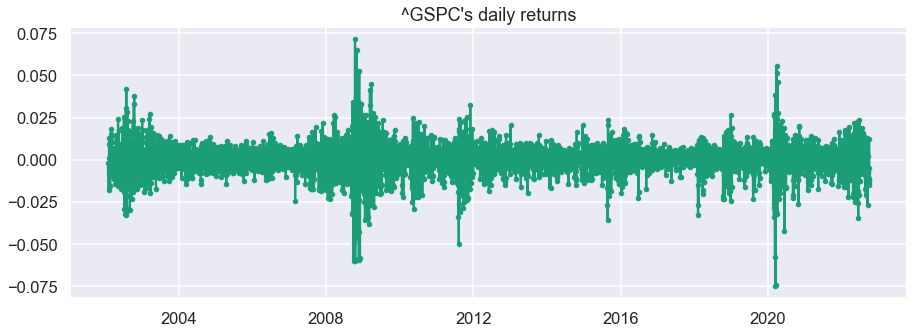

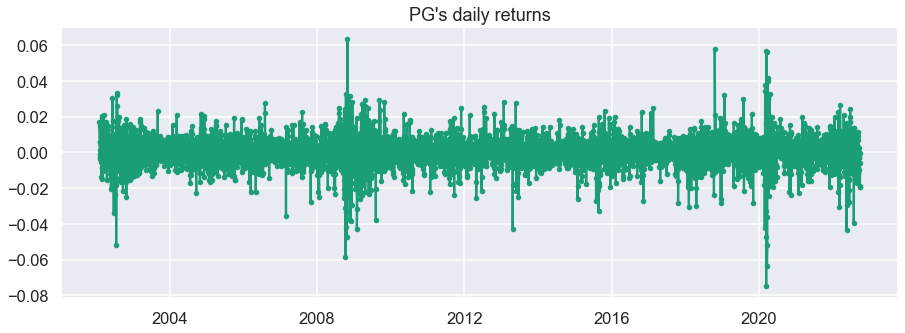

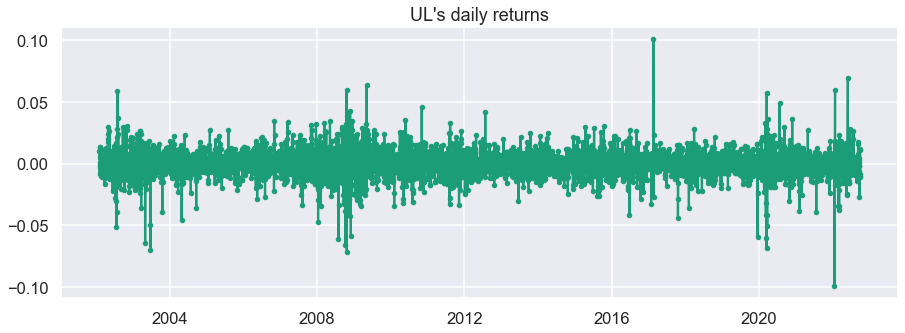

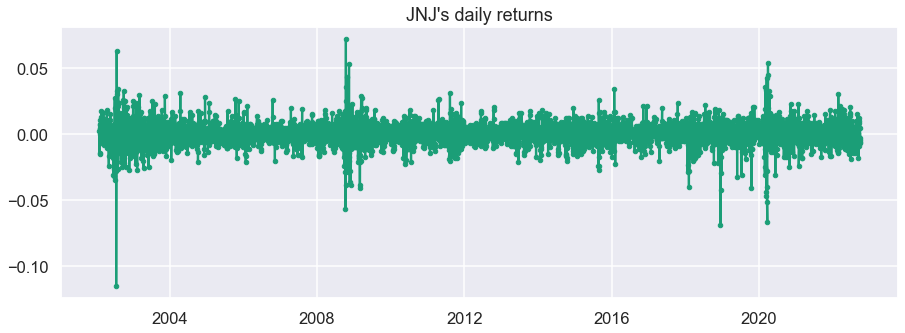

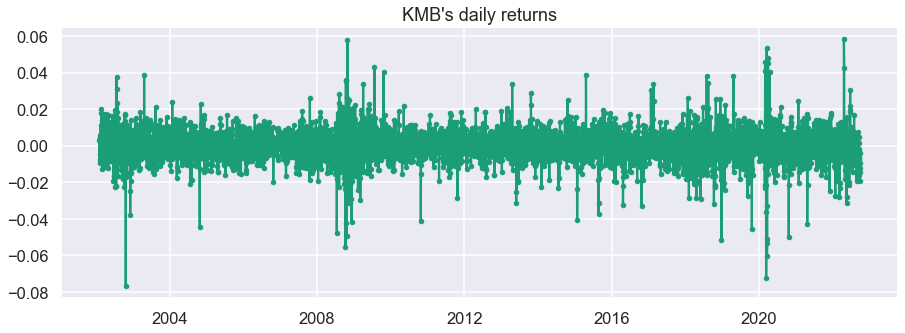

In [30]:
daily_returns = {}
for i in stock_list:
    daily_returns[i] = stocks[i]['close'].pct_change()
    plt.figure(figsize=(15,5))
    plt.title("{}'s daily returns".format(i))
    plt.plot(daily_returns[i], marker='.')

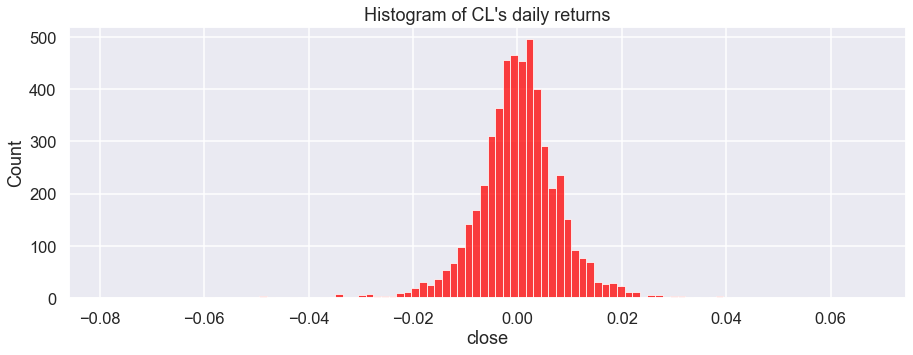

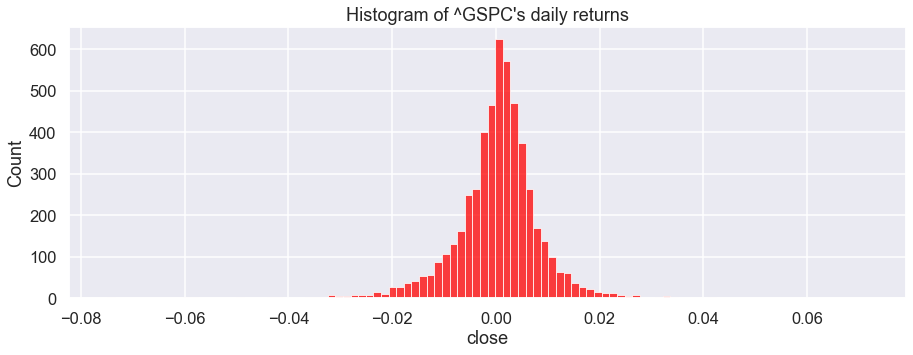

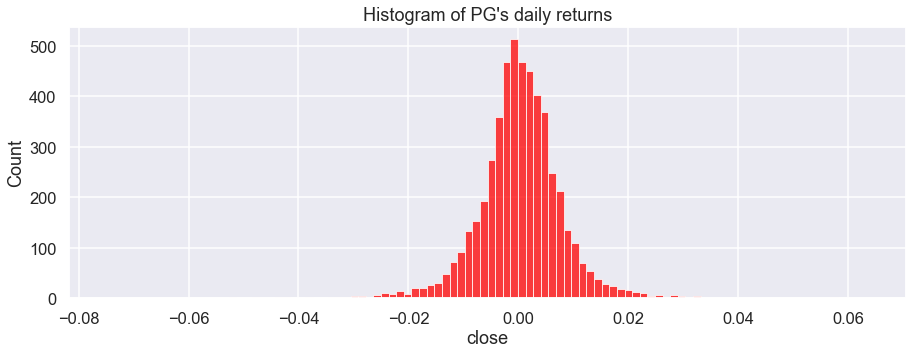

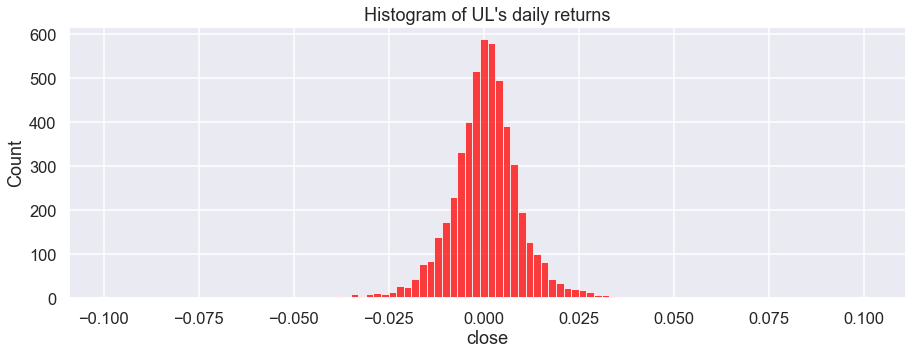

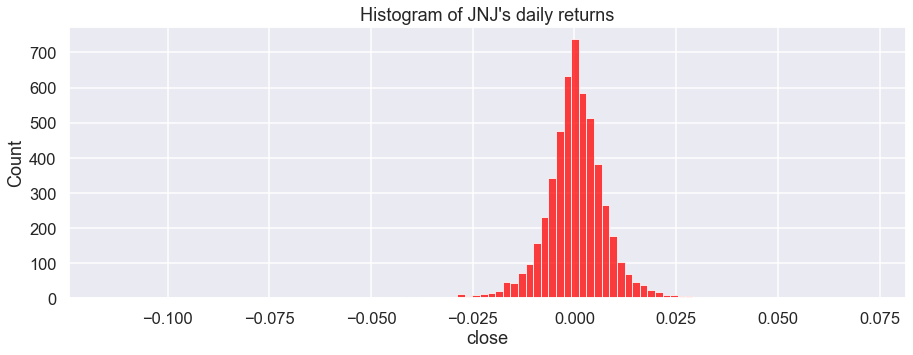

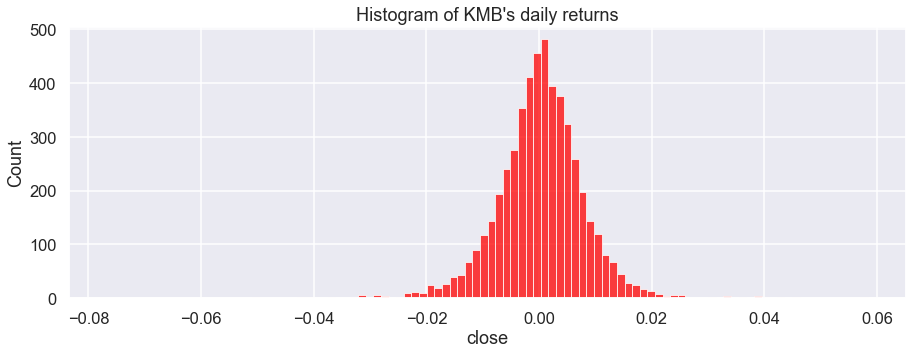

In [31]:
for i in stock_list:
    plt.figure(figsize=(15,5))
    sns.histplot(x=daily_returns[i],bins=100,color='red')
    plt.title("Histogram of {}'s daily returns".format(i))

## Summary and thoughts

- Stock levels are stochastic and therefore follow random paths. We cannot use statistical or deep learning techniques on a random walk since it moves at random in the future. Therefore, we must use naïve forecasts. 


- Another problem with predicting price levels is that it often times can be misleading since error is reported as MSE and thus doesnt take account for overall direction, only distance from actual values. Even if the prediction is good from the standpoint that it is close to the actual value, if you consistently predict in the wrong direction you will lose money! Therefore it makes more sense to perhaps predict price direction since that will help us more in the act of making money.


- Additionally since our model is built on a sliding window sequence of 20 days, we would only be able to predict for one day out. In other words forecasting typically isn't predict Novem 1st on Oct 31st. We are limited because for each day we want to predict, we have to have the previous 20 days worth of data to get our prediction. This may still be usefull however as a better than guessing idea of price level for the next day however. Ideally, we forecast a random walk in the short-term or next timestep. That way, we do not allow for random numbers to accumulate, which will degrade the quality of our forecasts in the long-term.


- Hence if we combined our daily predictions as well as a daily market prediction we may have a useful short term tool for guessing the ending price for the following day.


- To focus on predicting direction we can shift our attention towards returns. Since in finance, investors often work with log returns. Log returns = difference in log prices which are almost stationary (almost due to clusters of volatility) which is still exceptable for forecasting.


Here is a link to a publication for additional reading on predicting short term market direction instead of predicting prices. It also contains citations to even more reading if interested. https://jfin-swufe.springeropen.com/articles/10.1186/s40854-019-0138-0